Attempts to use the scenedetect - Python library to detect the boundaries of events. Version: 0.6.1

PySceneDetect docs: http://scenedetect.com/projects/Manual/en/latest/api.html

In [65]:
# imports

import pandas as pd
from scenedetect import open_video, SceneManager, StatsManager
from scenedetect.detectors import ContentDetector
import os

In [3]:
# function to detect changes in video

def detect_changes(video_path, threshold):
    video = open_video(video_path)
    stats_manager = StatsManager()
    scene_manager = SceneManager(stats_manager=stats_manager)

    scene_manager.add_detector(
        ContentDetector(threshold=threshold))
    
    # detect potential boundaries of scenes
    scene_manager.detect_scenes(video, show_progress=True)

    # save processed video statistics
    stats_manager.save_to_csv('scenedetect_metrics.csv')

In [4]:
# read all videos

dir_path = 'videos'
files = []

for path in os.listdir(dir_path):
    if os.path.isfile(os.path.join(dir_path, path)):
        files.append(path)

files.sort()

Detected: 1 | Progress: 100%|██████████| 1656/1656 [00:03<00:00, 461.73frames/s]
Detected: 10 | Progress: 100%|██████████| 1521/1521 [00:03<00:00, 449.47frames/s]
Detected: 8 | Progress: 100%|██████████| 1234/1234 [00:02<00:00, 448.69frames/s]
Detected: 4 | Progress: 100%|██████████| 1280/1280 [00:02<00:00, 449.82frames/s]
Detected: 2 | Progress: 100%|██████████| 901/901 [00:02<00:00, 394.75frames/s]
Detected: 1 | Progress: 100%|██████████| 1045/1045 [00:02<00:00, 358.45frames/s]
Detected: 1 | Progress: 100%|██████████| 1282/1282 [00:04<00:00, 257.33frames/s]
Detected: 4 | Progress: 100%|██████████| 1350/1350 [00:05<00:00, 255.25frames/s]
Detected: 1 | Progress: 100%|██████████| 1140/1140 [00:04<00:00, 255.64frames/s]


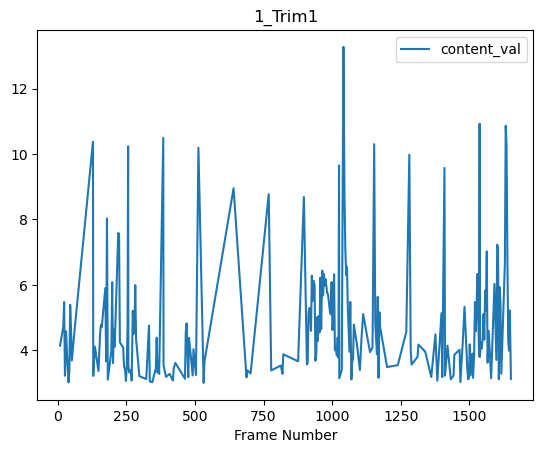

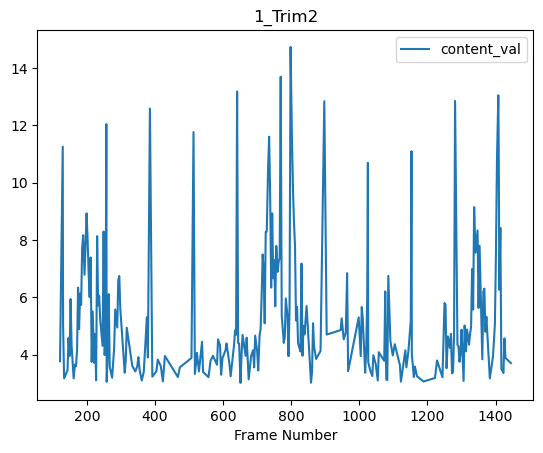

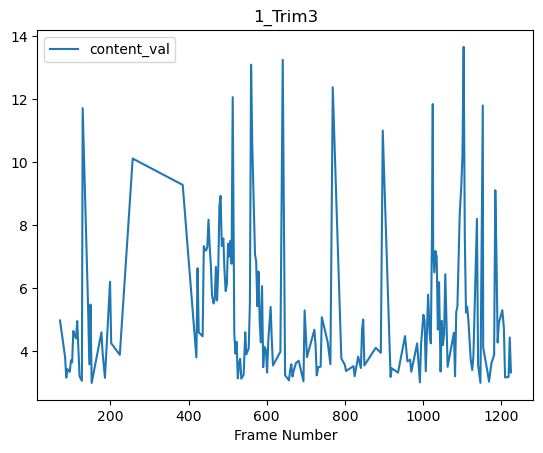

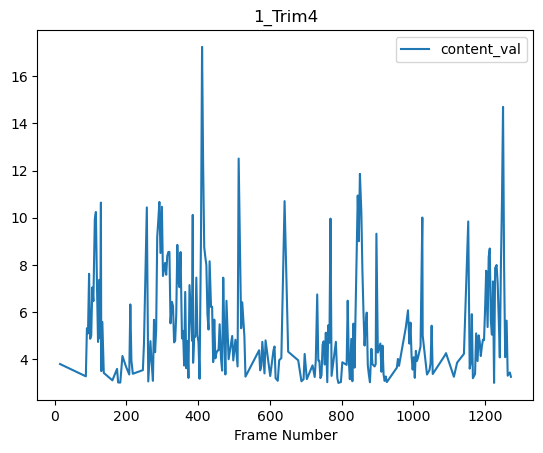

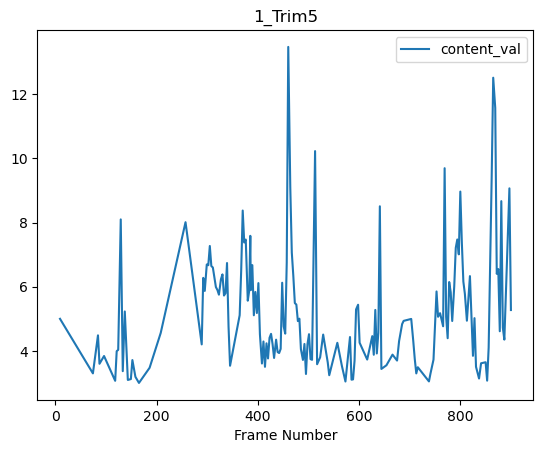

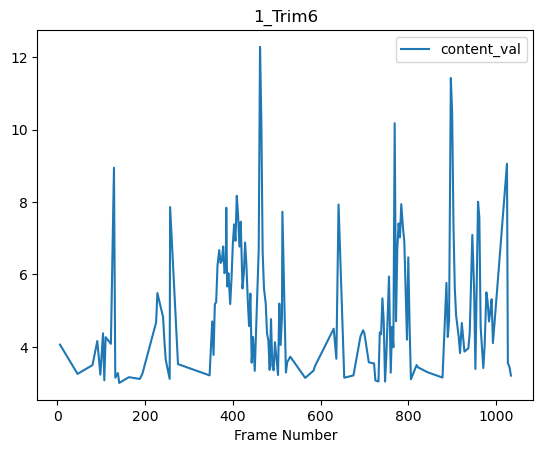

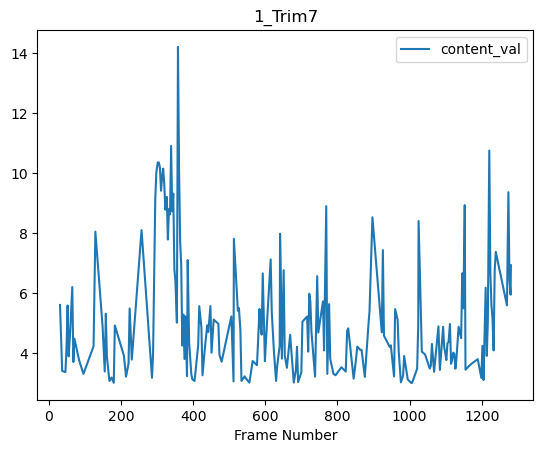

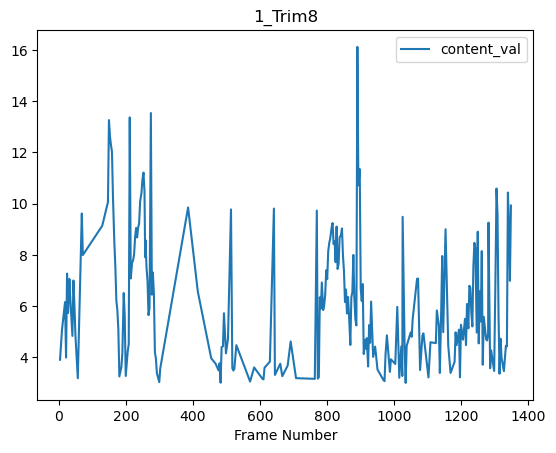

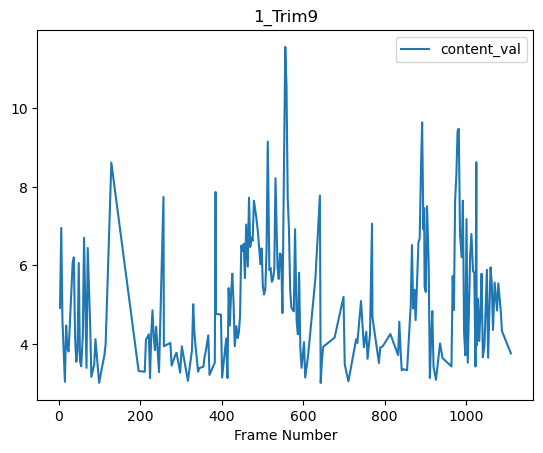

In [80]:
# detect changes in all videos

event_change_test = pd.DataFrame(columns=["video", "event_change"])

for file in files:
    filename, file_extension = os.path.splitext(f'{file}')

    # set threshold do 11.0
    detect_changes(f'videos/{file}', threshold=11.5)
    
    # read saved csv file and filter lowest values
    graph = pd.read_csv('scenedetect_metrics.csv')
    content_val = graph[graph['content_val'] > 3]

    # plot graph of frame numbers to content values and save into file
    # note: he peaks in values correspond to the scene breaks in the input video
    # in some cases the threshold may need to be raised or lowered accordingly
    fig = content_val.plot.line(x='Frame Number', y='content_val', title=f'{filename}').get_figure()
    fig.savefig(f'graphs/{filename}.jpg')

    # take highest value to get the most significant scene break
    max_value = graph['content_val'].idxmax()
    change = graph[graph['Frame Number'] == max_value]
    change_event = change.iloc[0]['Timecode']

    df = pd.DataFrame([{"video": f'{file}', "event_change": f'{change_event}'}])
    event_change_test = pd.concat([event_change_test, df])

# save test preprocessed data to csv
event_change_test.to_csv('test_data.csv', index=False)


In [73]:
# read true data

df = pd.read_csv('data.csv')

videos = df['video'].tolist()
event_change_true = pd.to_datetime(df['event_change'], format='%H:%M:%S.%f').dt.time

event_change_true = event_change_true.tolist()

In [74]:
# read test data

df = pd.read_csv('test_data.csv')

videos = df['video'].tolist()
event_change_test = pd.to_datetime(df['event_change'], format='%H:%M:%S.%f').dt.time

event_change_test = event_change_test.tolist()

In [75]:
# compare results

correct_detection = 0

for true_change, test_change in zip(event_change_true, event_change_test):
    # convert true and test time
    true_time = true_change.second + true_change.microsecond/1000000
    test_time = test_change.second + test_change.microsecond/1000000

    # include measurement uncertainty
    lower_tolerance = true_time - 0.250
    upper_tolerance = true_time + 0.250

    if ((test_time > lower_tolerance) and (test_time < upper_tolerance)):
        correct_detection += 1

print(f"accuracy: {round(correct_detection/len(event_change_true)*100, 2)}%")

accuracy: 88.89%


Preliminary findings: 
Changing the threshold affects the detection of more potential scene boundaries. After filtering, the final result remains unchanged. It was assumed that the highest "content value" corresponds to the most important and significant event - in this case, the puncture of the membrane of the ovum. Other detected events resulted from errors during the procedure itself, as well as poor quality recordings.